## Project Phase 1 - Aviation Accident Data Integration
### Group 03:
- Tommaso Tragno - fc64699
- Manuel Cardoso - fc56274
- Chen Cheng - fc64872
- Cristian Tedesco - fc65149

#### Setup

In [4]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import os
import time
import seaborn as sns
import calendar
import py_stringmatching as sm
import re

### 1. Data Loading

In [2]:
PATH = 'data_sources/'
FILTERED_PATH = 'filtered/'

NTSB_DATA = 'ntsb-us-2003-2023.json'
AIR_TRAFFIC_DATA = 'u-s-airline-traffic-data.csv'
AIRCRAFT_DATA = 'combined_aircraft_data.csv' 
WEATHER_DATA = 'weather_results.json'

#### Load NTSB JSON Data

In [6]:
with open(PATH+NTSB_DATA, 'r', encoding='utf-8') as f:
    ntsb_raw_data = json.load(f)

# Each record is one accident/incident entry in a list
print(f'\n--- NTSB JSON loaded: {len(ntsb_raw_data)} total records found ---')

# Convert to a DataFrame (this will flatten top-level fields)
# For nested fields like 'Vehicles', we might do a separate flatten later
df_ntsb = pd.json_normalize(ntsb_raw_data, 
                            meta=[
                                'Oid','MKey','Closed','CompletionStatus','HasSafetyRec',
                                'HighestInjury','IsStudy','Mode','NtsbNumber',
                                'OriginalPublishedDate','MostRecentReportType','ProbableCause',
                                'City','Country','EventDate','State','Agency','BoardLaunch',
                                'BoardMeetingDate','DocketDate','EventType','Launch','ReportDate',
                                'ReportNum','ReportType','AirportId','AirportName','AnalysisNarrative',
                                'FactualNarrative','PrelimNarrative','FatalInjuryCount','MinorInjuryCount',
                                'SeriousInjuryCount','InvestigationClass','AccidentSiteCondition',
                                'Latitude','Longitude','DocketOriginalPublishDate'
                            ],
                            record_path=['Vehicles'],  # This flattens out the 'Vehicles' array
                            record_prefix='Vehicles.'
                           )

print('\n--- Flattened NTSB DataFrame (including Vehicles info): ---')

## print(df_ntsb.info())

# combines all injury counts to 1 column
df_ntsb['TotalInjuryCount'] = df_ntsb[['FatalInjuryCount', 'MinorInjuryCount', 'SeriousInjuryCount']].sum(axis=1)

# dropping unnecessary columns
df_ntsb.drop(columns=['AnalysisNarrative','FactualNarrative','PrelimNarrative','InvestigationClass','BoardLaunch'
                      ,'BoardMeetingDate','Launch','IsStudy','OriginalPublishedDate','DocketOriginalPublishDate'
                      ,'ReportType','ReportNum','ReportDate','MostRecentReportType','FatalInjuryCount','MinorInjuryCount'
                      ,'SeriousInjuryCount','DocketDate','Mode','HasSafetyRec','CompletionStatus','Closed'
                      ,'Vehicles.AircraftCategory','Vehicles.AmateurBuilt','Vehicles.EventID','Vehicles.AirMedical'
                      ,'Vehicles.AirMedicalType','Vehicles.flightScheduledType','Vehicles.flightServiceType'
                      ,'Vehicles.flightTerminalType','Vehicles.RegisteredOwner','Vehicles.RegulationFlightConductedUnder'
                      ,'Vehicles.RepGenFlag','Vehicles.RevenueSightseeing','Vehicles.SecondPilotPresent','Vehicles.Damage'
                      ,'AccidentSiteCondition'], inplace=True) 

# dropping NaT entries from EventDate
df_ntsb = df_ntsb.dropna(subset=['EventDate'])

df_ntsb = df_ntsb.map(lambda x: x.lower() if isinstance(x, str) else x) # make all appropriate values lowercase

# Type Conversion
df_ntsb['EventDate'] = pd.to_datetime(df_ntsb['EventDate']).dt.tz_localize(None)
df_ntsb['Vehicles.VehicleNumber'] = pd.to_numeric(df_ntsb['Vehicles.VehicleNumber'], errors='coerce').astype(int)
df_ntsb['MKey'] = pd.to_numeric(df_ntsb['MKey'], errors='coerce').astype(int)
df_ntsb['Vehicles.NumberOfEngines'] = pd.to_numeric(df_ntsb['Vehicles.NumberOfEngines'], errors='coerce').fillna(0).astype(int)
df_ntsb['Latitude'] = pd.to_numeric(df_ntsb['Latitude'], errors='coerce').astype(float)
df_ntsb['Longitude'] = pd.to_numeric(df_ntsb['Longitude'], errors='coerce').astype(float)
df_ntsb['TotalInjuryCount'] = pd.to_numeric(df_ntsb['TotalInjuryCount'], errors='coerce').astype(int)

###### cosa fare con ProbableCause?
########################### SerialNumber ?? RegistrationNumber ?? Oid?? NtsbNumber?? AirportId??



categorical_cols = [
    'Vehicles.DamageLevel',
    'Vehicles.ExplosionType',
    'Vehicles.FireType',
    'HighestInjury',
    'EventType',
    'AccidentSiteCondition',
    'Vehicles.Make',
    'Vehicles.Model',
    'Vehicles.FlightOperationType',
    'Vehicles.OperatorName',
    'City',
    'Country',
    'State',
    'Agency',
    'EventType',
    'AirportName',
    'AirportId'
    
    	
]

for col in categorical_cols:
    if col in df_ntsb.columns:
        df_ntsb[col] = df_ntsb[col].astype('category')



print(df_ntsb.info())

print('\n--- Saving filtered NTSB DataFrame... ---')
df_ntsb.to_pickle(PATH+'filtered/ntsb.pkl')


--- NTSB JSON loaded: 22992 total records found ---

--- Flattened NTSB DataFrame (including Vehicles info): ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23403 entries, 0 to 23402
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Vehicles.VehicleNumber        23403 non-null  int32         
 1   Vehicles.DamageLevel          23400 non-null  category      
 2   Vehicles.ExplosionType        21880 non-null  category      
 3   Vehicles.FireType             23321 non-null  category      
 4   Vehicles.SerialNumber         23283 non-null  object        
 5   Vehicles.Make                 23402 non-null  category      
 6   Vehicles.Model                23398 non-null  category      
 7   Vehicles.NumberOfEngines      23403 non-null  int32         
 8   Vehicles.RegistrationNumber   23397 non-null  object        
 9   Vehicles.FlightOperationType  21593 non-null  

In [4]:
print(df_ntsb['Vehicles.Make'])

0                   cirrus design corp
1                    golden avio s r l
2                   piper aircraft inc
3                             bellanca
4                                maule
                     ...              
23398                           cessna
23399                           cessna
23400                 grumman american
23401    aircraft mfg & dev. co. (amd)
23402                            beech
Name: Vehicles.Make, Length: 23403, dtype: category
Categories (1097, object): ['177mf llc', '2021fx3 llc', 'ab sportine aviacija', 'ac mfg & dev't co', ..., 'zlin', 'zlin aviation', 'zlin aviation s r o', 'zlin aviation s.r.o.']


#### Load Weather JSON Data
(after fetching the data from open-meteo API)

In [5]:
with open(PATH+WEATHER_DATA, 'r', encoding='utf-8') as f:
    weather_raw_data = json.load(f)

# Each record is one day weather entry in a list
print(f'\n--- Weather JSON loaded: {len(weather_raw_data)} total records found ---')

# weather_data is a dict, e.g.:
# {
#   "cen24la079_2023-12-31_41.610278_-90.588361": {
#       "time": [...],
#       "temperature_2m": [...],
#       ...
#   }
# }

# Flatten into a tabular structure
all_rows = []
num_skip = 0

for accident_id, subdict in weather_raw_data.items():
    # subdict is a dict with keys like "time", "temperature_2m", ...
    # Each key is an array of the same length (24 hours).
    times = subdict.get("time", None)
    if times is None:
        print(f'Skipping {accident_id}: no "time" found.')
        num_skip += 1
        continue
    num_hours = len(subdict["time"])
    for i in range(num_hours):
        row = {"AccidentID": accident_id}  # store the top-level key
        for param, values_array in subdict.items():
            # param: "time", "temperature_2m", ...
            row[param] = values_array[i]  # pick the ith hour’s value
        all_rows.append(row)

df_weather = pd.DataFrame(all_rows)

# The missing values exists because not all accident have position data
# this cause the api to return empty data.
print("Skipped {} records over {} accidents.".format(num_skip, len(weather_raw_data.items())))

# Type conversion
df_weather["time"] = pd.to_datetime(df_weather["time"], errors="coerce")

int_columns = [
    "relative_humidity_2m",
    "cloud_cover_low",
    "cloud_cover_mid",
    "cloud_cover_high",
    "wind_direction_10m",
    "wind_direction_100m",
    "weather_code"
]
float_columns = [
    "temperature_2m",
    "dew_point_2m",
    "pressure_msl",
    "surface_pressure",
    "precipitation",
    "rain",
    "snowfall",
    "wind_speed_10m",
    "wind_speed_100m",
    "wind_gusts_10m",
    "snow_depth"
]
for col in int_columns:
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce").astype(int)
for col in float_columns:
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce").astype(float)


print("\n--- Weather DataFrame sample ---")
print(df_weather.info())

print('\n--- Saving filtered Weather DataFrame... ---')
df_weather.to_pickle(PATH+'filtered/weather.pkl')


--- Weather JSON loaded: 20790 total records found ---
Skipping dca23wa432_2023-08-30_nan_nan: no "time" found.
Skipping cen23la030_2022-11-06_43511185.0_-1004241.0: no "time" found.
Skipping cen23la029_2022-11-02_390408.0_-953721.0: no "time" found.
Skipping cen23la020_2022-10-26_36940.21_-932048.49: no "time" found.
Skipping cen22la385_2022-08-10_43.12951_-85.67947: no "time" found.
Skipping cen22la310_2022-07-10_41.349_-894627.0: no "time" found.
Skipping cen22la180_2022-04-14_30.746616_-95.587956: no "time" found.
Skipping dca22wa057_2021-11-30_nan_nan: no "time" found.
Skipping dca21wa207_2021-08-14_nan_nan: no "time" found.
Skipping wpr21la163_2021-04-18_4603.0_-1041.12: no "time" found.
Skipping era18la213_2018-07-25_33.938888_-81.119445: no "time" found.
Skipping dca18wa177_2018-05-08_nan_nan: no "time" found.
Skipping cen16la033_2015-11-06_30.240554_-90.915275: no "time" found.
Skipping era16fa033_2015-11-06_27.2075_-80.842498: no "time" found.
Skipping era16fa032_2015-11-05_

#### Load Airline Traffic CSV Data

In [7]:
df_airline_traffic = pd.read_csv(PATH+AIR_TRAFFIC_DATA, encoding='utf-8')

print(f'\n--- Airline CSV loaded: {df_airline_traffic.shape[0]} rows, {df_airline_traffic.shape[1]} columns ---')

# dropping unnecessary columns
df_airline_traffic.drop(columns=['Dom_RPM','Int_RPM','RPM','Dom_ASM','Int_ASM','ASM'], inplace=True) 

# print(df_airline_traffic.info())

# Remove commas from all columns and then convert
df_airline_traffic = df_airline_traffic.replace(',', '', regex=True)

# Now convert each column to numeric. If everything converts well, no rows become NaN.
df_airline_traffic = df_airline_traffic.apply(pd.to_numeric, errors='coerce').astype(int)

print(df_airline_traffic.info())

print('\n--- Saving filtered Airline DataFrame... ---')
df_airline_traffic.to_pickle(PATH+'filtered/airline.pkl')


--- Airline CSV loaded: 249 rows, 17 columns ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Year     249 non-null    int32
 1   Month    249 non-null    int32
 2   Dom_Pax  249 non-null    int32
 3   Int_Pax  249 non-null    int32
 4   Pax      249 non-null    int32
 5   Dom_Flt  249 non-null    int32
 6   Int_Flt  249 non-null    int32
 7   Flt      249 non-null    int32
 8   Dom_LF   249 non-null    int32
 9   Int_LF   249 non-null    int32
 10  LF       249 non-null    int32
dtypes: int32(11)
memory usage: 10.8 KB
None

--- Saving filtered Airline DataFrame... ---


#### Load Aircraft ICAO Data

In [7]:

df_aircraft = pd.read_csv(PATH+AIRCRAFT_DATA)

# === 1. Data Cleaning and Normalization ===
def clean_text(s):
    """ Normalizzazione del testo: rimozione di caratteri speciali, lowercase e spazi extra. """
    return re.sub(r'\W+', ' ', str(s)).lower().strip()

# applica la normalizzazione
for col in ['model_no', 'manufacturer_code']:
    df_aircraft[col] = df_aircraft[col].apply(clean_text)

# rimuovi le righe senza model_no
df_aircraft.dropna(subset=['model_no'], inplace=True)

# === 2. Type conversion ===
# drop model_version (100% missing)
if 'model_version' in df_aircraft.columns:
    df_aircraft.drop(columns=['model_version'], inplace=True)

# cast alle categorie e numerici
df_aircraft = df_aircraft.astype({
    'manufacturer_code': 'category',
    'model_name'       : 'category',
    'model_no'         : 'category',
    'engine_count'     : 'int64',
    'engine_type'      : 'category',
    'aircraft_desc'    : 'category',
    'description'      : 'category',
    'wtc'              : 'category',
    'tdesig'           : 'category',
    'wtg'              : 'category'
})

# === 3. Profiling ===
ICAO_model_profile = profile_dataframe(df_aircraft, name='ICAO Data')
display(HTML(ICAO_model_profile.to_html()))
ICAO_model_profile.to_csv(PATH+'profiling/ICAO_model_profile.csv', index=False)


NameError: name 'profile_dataframe' is not defined

### 2. Data Profiling

In [7]:
def profile_dataframe(df, name='DataFrame'):
    print(f'\n=== Profiling {name} ===')
    print(f'Total Rows: {len(df)}')
    print(f'Total Columns: {len(df.columns)}\n')
    
    profile_results = []

    for col in df.columns:
        series = df[col]
        col_dtype = series.dtype
        
        # Basic counts
        total_count = len(series)
        missing_vals = series.isna().sum()
        non_null_count = total_count - missing_vals
        missing_perc = (missing_vals / total_count) * 100
        unique_vals = series.nunique(dropna=False)
        
        # Mode & frequency
        try:
            modes = series.mode(dropna=True)
            mode_val = modes.iloc[0] if len(modes) > 0 else np.nan
            mode_freq = (series == mode_val).sum(skipna=True)
        except:
            mode_val, mode_freq = np.nan, np.nan
        
        # Initialize placeholders
        mean_ = np.nan
        min_  = np.nan
        q25   = np.nan
        q50   = np.nan
        q75   = np.nan
        max_  = np.nan
        std_  = np.nan  # only for numeric columns

        # Numeric columns
        if pd.api.types.is_numeric_dtype(series):
            mean_ = series.mean(skipna=True)
            min_  = series.min(skipna=True)
            q25   = series.quantile(0.25)
            q50   = series.quantile(0.50)
            q75   = series.quantile(0.75)
            max_  = series.max(skipna=True)
            std_  = series.std(skipna=True)

        # Datetime columns
        elif pd.api.types.is_datetime64_any_dtype(series):
            # We can compute mean & quartiles by time. 
            # .quantile() and .mean() are valid for datetime in pandas
            # They return a Timestamp for mean, 
            # and Timestamps for quantiles
            if non_null_count > 0:
                mean_ = series.mean(skipna=True)
                min_  = series.min(skipna=True)
                q25   = series.quantile(0.25)
                q50   = series.quantile(0.50)
                q75   = series.quantile(0.75)
                max_  = series.max(skipna=True)
            # We skip std_ for datetime.

        # Categorical/object columns 
        # do not get numeric stats (we keep them as NaN).

        profile_results.append((
            col,
            str(col_dtype),
            total_count,
            non_null_count,
            missing_vals,
            round(missing_perc, 2),
            unique_vals,
            mode_val,
            mode_freq,
            mean_,
            min_,
            q25,
            q50,
            q75,
            max_,
            std_
        ))

    columns = [
        'Column', 'DataType', 'TotalCount', 'NonNullCount', 'NumMissing',
        'MissingPerc', 'Cardinality', 'Mode', 'ModeFreq',
        'Mean', 'Min', 'Q25', 'Q50', 'Q75', 'Max', 'Std'
    ]

    prof_df = pd.DataFrame(profile_results, columns=columns)
    
    return prof_df

#### NTSB Data Profile

In [22]:
ntsb_profile = profile_dataframe(df_ntsb, name='NTSB Data')
display(HTML(ntsb_profile.to_html()))
ntsb_profile.to_csv(PATH+'profiling/ntsb_profile.csv', index=False)


=== Profiling NTSB Data ===
Total Rows: 23403
Total Columns: 27



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,Vehicles.VehicleNumber,int32,23403,23403,0,0.00,3,1,22986,1.018117,1,1.0,1.0,1.0,3,0.135603
1,Vehicles.DamageLevel,category,23403,23400,3,0.01,6,substantial,19718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Vehicles.ExplosionType,category,23403,21880,1523,6.51,6,none,21306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Vehicles.FireType,category,23403,23321,82,0.35,7,none,20993,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Vehicles.SerialNumber,object,23403,23283,120,0.51,21514,001,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Vehicles.Make,category,23403,23402,1,0.00,1098,cessna,8191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Vehicles.Model,category,23403,23398,5,0.02,3362,172,762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Vehicles.NumberOfEngines,int32,23403,23403,0,0.00,5,1,19416,1.13823,0,1.0,1.0,1.0,4,0.422117
8,Vehicles.RegistrationNumber,object,23403,23397,6,0.03,22386,unreg,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Vehicles.FlightOperationType,category,23403,21593,1810,7.73,22,pers,14516,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Insights from the data profile results:

- there are some `null` values for Latitude and Longitude --> we keep like this, but they should be handled during the API calls to open-meteo
- there are less unique `NtsbNumber` than rows --> for incident where more than one aircraft is involved, the rows are duplicated with different values for Vehicles characteristic, and same value for incident data (look at the following example)

In [10]:
df_ntsb.loc[df_ntsb['NtsbNumber']=='ops24la011']

,Vehicles.VehicleNumber,Vehicles.DamageLevel,Vehicles.ExplosionType,Vehicles.FireType,Vehicles.SerialNumber,Vehicles.Make,Vehicles.Model,Vehicles.NumberOfEngines,Vehicles.RegistrationNumber,Vehicles.FlightOperationType,...,Country,EventDate,State,Agency,EventType,AirportId,AirportName,Latitude,Longitude,TotalInjuryCount
39,1,none,none,none,c0218,diamond aircraft ind inc,da20-c1,1,n857pa,NaN,...,usa,2023-12-09 13:06:00,nv,ntsb,occ,vgt,north las vegas,36.211268,-115.19968,0
40,2,none,none,none,1955,robinson helicopter,r44,1,n744af,NaN,...,usa,2023-12-09 13:06:00,nv,ntsb,occ,vgt,north las vegas,36.211268,-115.19968,0


#### Weather Data Profile

In [11]:
weather_profile = profile_dataframe(df_weather, name='Weather Data')
display(HTML(weather_profile.to_html()))
weather_profile.to_csv(PATH+'profiling/weather_profile.csv', index=False)


=== Profiling Weather Data ===
Total Rows: 491592
Total Columns: 21



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,AccidentID,object,491592,491592,0,0.00,20483,anc04ca085_2004-08-04_65.697502_-156.351104,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,time,datetime64[ns],491592,491592,0,0.00,155280,2011-06-18 00:00:00,14,2013-08-13 21:55:37.157643008,2004-07-24 00:00:00,2008-08-17 17:45:00,2013-03-11 02:30:00,2018-06-19 07:00:00,2023-12-31 23:00:00,NaN
2,temperature_2m,float64,491592,491592,0,0.00,806,23.5,1994,15.903267,-36.0,9.1,17.3,23.9,46.2,10.640686
3,relative_humidity_2m,int32,491592,491592,0,0.00,100,84,8307,64.547621,1,49.0,68.0,83.0,100,22.852449
4,dew_point_2m,float64,491592,491592,0,0.00,659,11.4,1969,7.872516,-39.5,0.9,8.9,15.9,27.6,10.155472
5,pressure_msl,float64,491592,491592,0,0.00,820,1015.6,3616,1015.685346,962.4,1011.8,1015.6,1019.7,1053.2,6.923077
6,surface_pressure,float64,491592,491592,0,0.00,3907,1014.0,1154,967.432852,602.2,958.7,990.6,1008.8,1041.5,62.377769
7,precipitation,float64,491592,491592,0,0.00,163,0.0,442059,0.074952,0.0,0.0,0.0,0.0,37.0,0.456493
8,rain,float64,491592,491592,0,0.00,163,0.0,446844,0.069873,0.0,0.0,0.0,0.0,37.0,0.450826
9,snowfall,float64,491592,491592,0,0.00,44,0.0,484116,0.003738,0.0,0.0,0.0,0.0,3.78,0.048473


#### Air Traffic Data Profile

In [12]:
airline_profile = profile_dataframe(df_airline_traffic, name='Airline Data')
display(HTML(airline_profile.to_html()))
airline_profile.to_csv(PATH+'profiling/airline_profile.csv', index=False)


=== Profiling Airline Data ===
Total Rows: 249
Total Columns: 11



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,Year,int32,249,249,0,0.0,21,2003,12,2.012880e+03,2003,2008.0,2013.0,2018.0,2023,6.002817e+00
1,Month,int32,249,249,0,0.0,12,1,21,6.445783e+00,1,3.0,6.0,9.0,12,3.442803e+00
2,Dom_Pax,int32,249,249,0,0.0,249,2877290,1,5.520971e+07,2877290,50982170.0,56200104.0,60892131.0,75378157,1.044055e+07
3,Int_Pax,int32,249,249,0,0.0,249,136609,1,7.392209e+06,136609,6395022.0,7419187.0,8567847.0,12432615,2.020273e+06
4,Pax,int32,249,249,0,0.0,249,3013899,1,6.260192e+07,3013899,57664576.0,63899130.0,69447429.0,87810772,1.229211e+07
5,Dom_Flt,int32,249,249,0,0.0,249,217262,1,7.067507e+05,217262,662000.0,709933.0,781804.0,890938,1.070550e+05
6,Int_Flt,int32,249,249,0,0.0,248,63469,2,6.473617e+04,4996,61615.0,66557.0,71924.0,82681,1.212962e+04
7,Flt,int32,249,249,0,0.0,249,222280,1,7.714869e+05,222280,727898.0,779011.0,848650.0,964102,1.156867e+05
8,Dom_LF,int32,249,249,0,0.0,36,85,30,7.943775e+01,13,77.0,82.0,85.0,89,8.858494e+00
9,Int_LF,int32,249,249,0,0.0,41,79,23,7.681928e+01,23,76.0,79.0,82.0,89,1.087741e+01


#### Aircraft Data Profile

In [13]:
aircraft_profile = profile_dataframe(df_aircraft, name='Aircraft Data')
display(HTML(aircraft_profile.to_html()))
aircraft_profile.to_csv(PATH+'profiling/aircraft_profile.csv', index=False)


=== Profiling Aircraft Data ===
Total Rows: 2270
Total Columns: 10



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,manufacturer_code,category,2270,2270,0,0.00,35,cessna,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,model_no,category,2270,2270,0,0.00,1254,nan,659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,model_name,category,2270,1543,727,32.03,623,Huron,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,engine_count,int64,2270,2270,0,0.00,5,1,1152,1.580617,1.0,1.0,1.0,2.0,8.0,0.721375
4,engine_type,category,2270,2270,0,0.00,4,Piston,1242,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,aircraft_desc,category,2270,2270,0,0.00,4,LandPlane,2171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,description,category,2270,2270,0,0.00,18,L1P,970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,wtc,category,2270,2270,0,0.00,5,L,1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,tdesig,category,2270,2270,0,0.00,526,P28A,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,wtg,category,2270,2267,3,0.13,9,G,1775,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Insights from the data profile results:

- there are some `startDate` and `endDate` equal to 1 --> it is supposed to be a year

In [14]:
df_filtered = df_aircraft[(df_aircraft['startDate'] < 1000) | (df_aircraft['endDate'] < 1000)]
df_filtered.style.map(
    lambda val: 'background-color: red' if val < 1000 else '',
    subset=['startDate', 'endDate']
)

KeyError: 'startDate'

### Charts

    Month       Flt Month_Name
0       1  15719309        Jan
1       2  14510406        Feb
2       3  16693640        Mar
3       4  15822706        Apr
4       5  16417155        May
5       6  16606399        Jun
6       7  17434916        Jul
7       8  17361760        Aug
8       9  15770979        Sep
9      10  15622573        Oct
10     11  14910368        Nov
11     12  15230023        Dec


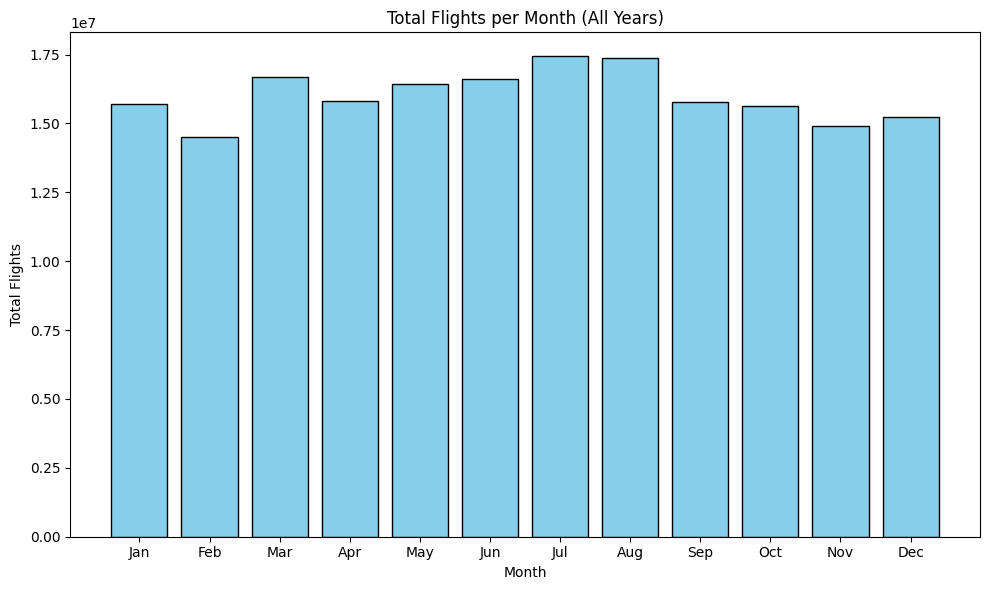

C:\Users\cri_t\AppData\Local\Temp\ipykernel_21168\2293526212.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_airline, x='Month_Name', y='Flt', order=month_order, palette='pastel')


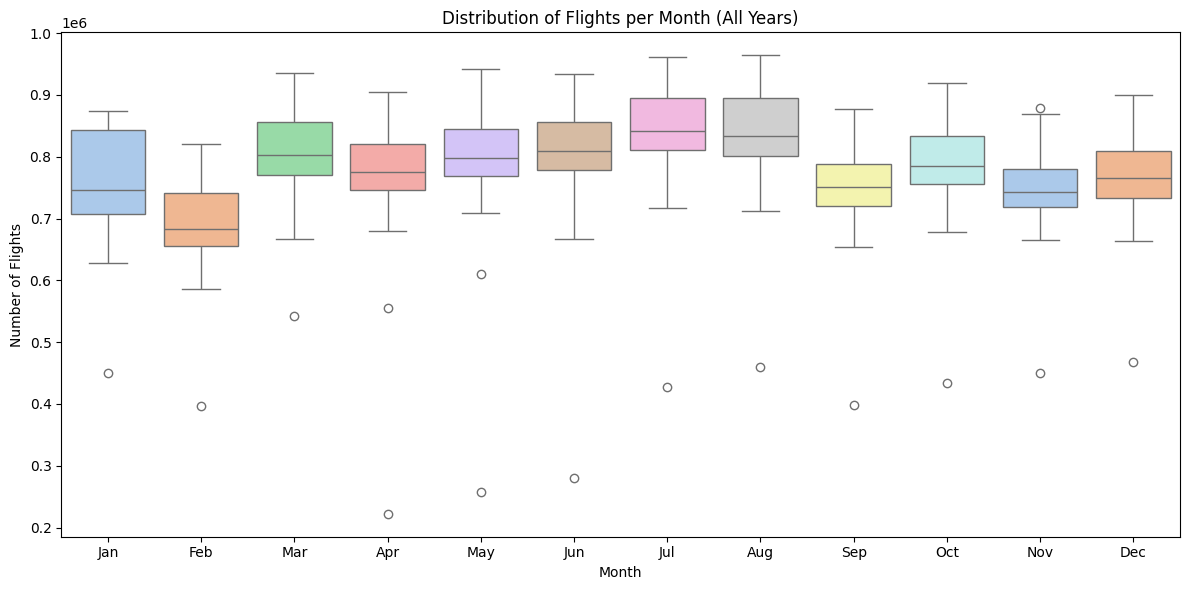

In [15]:
df_airline = pd.read_pickle(PATH + FILTERED_PATH + 'airline.pkl')

# Group by 'Month' and sum 'Flt'
monthly_flt_sum = df_airline.groupby('Month')['Flt'].sum().reset_index()

# Sort by month to be sure
monthly_flt_sum = monthly_flt_sum.sort_values('Month')

# Map month numbers to names (Jan, Feb, ...)
month_names = [calendar.month_abbr[m] for m in monthly_flt_sum['Month']]
monthly_flt_sum['Month_Name'] = month_names

# Display result
print(monthly_flt_sum)

# Histogram
# Plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_flt_sum['Month_Name'], monthly_flt_sum['Flt'], color='skyblue', edgecolor='black')

# Labels and title
plt.title('Total Flights per Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Total Flights')

plt.tight_layout()
plt.show()

# Box Plot
# Map numeric month to abbreviation
df_airline['Month_Name'] = df_airline['Month'].apply(lambda x: calendar.month_abbr[x])

# Optional: Order months correctly
month_order = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_airline, x='Month_Name', y='Flt', order=month_order, palette='pastel')

# Labels and title
plt.title('Distribution of Flights per Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Number of Flights')

plt.tight_layout()
plt.show()

## A blocking strategy

In [18]:

# === 1. Data Loading ===
# Caricamento dei dataset
df_aircraft = pd.read_csv('data_sources/combined_aircraft_data.csv')
df_ntsb = pd.read_pickle(PATH + FILTERED_PATH + 'ntsb.pkl')

# Selezione delle colonne necessarie
df_ntsb_model = df_ntsb[['NtsbNumber', 'EventDate', 'Vehicles.SerialNumber',
                         'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model']].copy()

# === 2. Data Cleaning and Normalization ===
def clean_text(s):
    """ Normalizzazione del testo: rimozione di caratteri speciali, lowercase e spazi extra. """
    return re.sub(r'\W+', ' ', str(s)).lower().strip()

# Pulizia dei dati
df_ntsb_model['Vehicles.Model'] = df_ntsb_model['Vehicles.Model'].apply(clean_text)
df_ntsb_model['Vehicles.Make'] = df_ntsb_model['Vehicles.Make'].apply(clean_text)

df_aircraft['model_no'] = df_aircraft['model_no'].apply(clean_text)
df_aircraft['manufacturer_code'] = df_aircraft['manufacturer_code'].apply(clean_text)

df_ntsb_model.dropna(subset=['Vehicles.Model'], inplace=True)
df_aircraft.dropna(subset=['model_no'], inplace=True)

# === 3. Similarity Setup ===
jw = sm.JaroWinkler()
lev = sm.Levenshtein()
jac = sm.Jaccard()  

# === 4. Precomputation degli n-gram ===
def generate_qgrams(model):
    """ Genera un insieme di trigrammi (q-grams di lunghezza 3) per una stringa data. """
    qgrams = [model[i:i+3] for i in range(len(model) - 2)]
    return set(qgrams)

# === 5. Matching with Optimized Loop ===
matches = []
matched_set = set()  # Set per controllare i duplicati di NtsbNumber + SerialNumber
serial_set = set()   # Set per controllare i duplicati di SerialNumber

for i, ntsb_row in df_ntsb_model.iterrows():
    model_ntsb = ntsb_row['Vehicles.Model']
    make_ntsb = ntsb_row['Vehicles.Make']
    grams_ntsb = generate_qgrams(model_ntsb)

    # 🔎 **Filtro preliminare basato sul Make (flessibile)**
    filtered_aircraft = df_aircraft[
        df_aircraft['manufacturer_code'].apply(lambda x: make_ntsb in x or x in make_ntsb or jw.get_sim_score(x, make_ntsb) > 0.85)
    ]
    
    # Se non ci sono candidati, passa al prossimo ciclo
    if filtered_aircraft.empty:
        continue

    # Precomputa gli n-gram per i candidati
    aircraft_grams = {index: generate_qgrams(model) for index, model in enumerate(filtered_aircraft['model_no'])}

    # 🔎 **Filtro preliminare basato sugli n-grammi**
    candidate_matches = []
    for idx, grams_aircraft in aircraft_grams.items():
        if len(grams_ntsb & grams_aircraft) >= 2:
            candidate_matches.append(filtered_aircraft.index[idx])

    if not candidate_matches:
        continue  # Nessun match possibile, passo al successivo

    # 🔎 **Controllo diretto:** se esiste un match esatto tra i candidati
    direct_match = df_aircraft.loc[candidate_matches]
    direct_match = direct_match[direct_match['model_no'] == model_ntsb]

    if not direct_match.empty:
        for _, row in direct_match.iterrows():
            match_id = f"{ntsb_row['NtsbNumber']}_{ntsb_row['Vehicles.SerialNumber']}_{row['model_no']}"
            if match_id not in matched_set and ntsb_row['Vehicles.SerialNumber'] not in serial_set:
                matches.append({
                    'NtsbNumber': ntsb_row['NtsbNumber'],
                    'EventDate': ntsb_row['EventDate'],
                    'Vehicles.SerialNumber': ntsb_row['Vehicles.SerialNumber'],
                    'Vehicles.RegistrationNumber': ntsb_row['Vehicles.RegistrationNumber'],
                    'Vehicles.Make': ntsb_row['Vehicles.Make'],
                    'Vehicles.Model': model_ntsb,
                    'Matched_Aircraft_Model': row['model_no'],
                    'engine_count': row['engine_count'],
                    'engine_type': row['engine_type'],
                    'JW_Score': 1.0,
                    'LEV_Score': 1.0,
                    'Jac_Score': 1.0,
                    'SimilarityScore': 1.0
                })
                matched_set.add(match_id)
                serial_set.add(ntsb_row['Vehicles.SerialNumber'])

        continue  # Salta il loop di matching

    # 🔎 **Controllo di Variante Generico**
    for idx in candidate_matches:
        model_aircraft = df_aircraft.loc[idx, 'model_no']

        # Numeric Filter: numbers must match if present
        nums_ntsb = re.findall(r'\d+', model_ntsb)
        nums_aircraft = re.findall(r'\d+', model_aircraft)

        if nums_ntsb and nums_aircraft and nums_ntsb != nums_aircraft:
            continue

        # Computing the Three Similarity Scores
        jw_score = jw.get_sim_score(model_ntsb, model_aircraft)
        lev_score = lev.get_sim_score(model_ntsb, model_aircraft)
        jac_score = jac.get_sim_score(list(grams_ntsb), list(generate_qgrams(model_aircraft)))

        # Linear Rule
        final_score = 0.4 * jw_score + 0.3 * lev_score + 0.3 * jac_score

        # Controllo duplicati
        match_id = f"{ntsb_row['NtsbNumber']}_{ntsb_row['Vehicles.SerialNumber']}_{model_aircraft}"
        if final_score > 0.75 and match_id not in matched_set and ntsb_row['Vehicles.SerialNumber'] not in serial_set:
            matches.append({
                'NtsbNumber': ntsb_row['NtsbNumber'],
                'EventDate': ntsb_row['EventDate'],
                'Vehicles.SerialNumber': ntsb_row['Vehicles.SerialNumber'],
                'Vehicles.RegistrationNumber': ntsb_row['Vehicles.RegistrationNumber'],
                'Vehicles.Make': ntsb_row['Vehicles.Make'],
                'Vehicles.Model': model_ntsb,
                'Matched_Aircraft_Model': model_aircraft,
                'engine_count': df_aircraft.loc[idx, 'engine_count'],
                'engine_type': df_aircraft.loc[idx, 'engine_type'],
                'JW_Score': round(jw_score, 3),
                'LEV_Score': round(lev_score, 3),
                'Jac_Score': round(jac_score, 3),
                'SimilarityScore': round(final_score, 4)
            })
            matched_set.add(match_id)
            serial_set.add(ntsb_row['Vehicles.SerialNumber'])

# === 6. Final Output ===
if not matches:
    print("No matches found with the current rules.")
else:
    df_matches = pd.DataFrame(matches)
    print(f"Matches Found: {len(df_matches)}")
    print("Columns:", df_matches.columns.tolist())
    df_matches = df_matches.sort_values(by='SimilarityScore', ascending=False)
    display(df_matches.head(25))


Matches Found: 4963
Columns: ['NtsbNumber', 'EventDate', 'Vehicles.SerialNumber', 'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model', 'Matched_Aircraft_Model', 'engine_count', 'engine_type', 'JW_Score', 'LEV_Score', 'Jac_Score', 'SimilarityScore']


,NtsbNumber,EventDate,Vehicles.SerialNumber,Vehicles.RegistrationNumber,Vehicles.Make,Vehicles.Model,Matched_Aircraft_Model,engine_count,engine_type,JW_Score,LEV_Score,Jac_Score,SimilarityScore
2481,era11la196,2011-03-19 14:10:00,28-24684,n7330j,piper,pa 28 140,pa 28 140,1,Piston,1.0,1.0,1.0,1.0
2574,cen10ca550,2010-09-19 20:45:00,28-26714,n333na,piper,pa 28 140,pa 28 140,1,Piston,1.0,1.0,1.0,1.0
2576,cen10ca547,2010-09-19 16:30:00,2842213,n436nd,piper,pa 28 161,pa 28 161,1,Piston,1.0,1.0,1.0,1.0
2577,era10la486,2010-09-19 12:30:00,28r-7535349,n799sq,piper,pa 28r 200,pa 28r 200,1,Piston,1.0,1.0,1.0,1.0
4380,lax04ca317,2004-09-14 08:30:00,3246185,n5300r,piper,pa 32r 301,pa 32r 301,1,Piston,1.0,1.0,1.0,1.0
2579,cen10ca582,2010-09-17 14:00:00,301-0354,n2309f,air tractor inc,at 301,at 301,1,Piston,1.0,1.0,1.0,1.0
2580,anc10la094,2010-09-15 18:40:00,18-7509044,n9699p,piper,pa 18,pa 18,1,Piston,1.0,1.0,1.0,1.0
2581,anc10la094,2010-09-15 18:40:00,18-4559,n2fd,piper,pa 18,pa 18,1,Piston,1.0,1.0,1.0,1.0
4379,ftw04la238,2004-09-14 18:15:00,31-7752154,n555mc,piper,pa 31 350,pa 31 350,2,Piston,1.0,1.0,1.0,1.0
4378,atl04ca186,2004-09-15 10:45:00,172rg1057,n948sm,cessna,172rg,172rg,1,Piston,1.0,1.0,1.0,1.0


#### All Match

In [19]:
display(df_matches)

,NtsbNumber,EventDate,Vehicles.SerialNumber,Vehicles.RegistrationNumber,Vehicles.Make,Vehicles.Model,Matched_Aircraft_Model,engine_count,engine_type,JW_Score,LEV_Score,Jac_Score,SimilarityScore
2481,era11la196,2011-03-19 14:10:00,28-24684,n7330j,piper,pa 28 140,pa 28 140,1,Piston,1.000,1.000,1.000,1.0000
2574,cen10ca550,2010-09-19 20:45:00,28-26714,n333na,piper,pa 28 140,pa 28 140,1,Piston,1.000,1.000,1.000,1.0000
2576,cen10ca547,2010-09-19 16:30:00,2842213,n436nd,piper,pa 28 161,pa 28 161,1,Piston,1.000,1.000,1.000,1.0000
2577,era10la486,2010-09-19 12:30:00,28r-7535349,n799sq,piper,pa 28r 200,pa 28r 200,1,Piston,1.000,1.000,1.000,1.0000
4380,lax04ca317,2004-09-14 08:30:00,3246185,n5300r,piper,pa 32r 301,pa 32r 301,1,Piston,1.000,1.000,1.000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,cen13la365,2013-06-19 14:18:00,32-8324009,n4296t,piper,pa 32 301t,pa 32r 301,1,Piston,0.960,0.800,0.455,0.7604
213,cen23fa079,2023-01-16 14:42:00,32-8024049,n8266d,piper,pa 32 301t,pa 32r 301,1,Piston,0.960,0.800,0.455,0.7604
4216,lax05la126,2005-03-27 15:40:00,32-8024035,n8243l,piper,pa 32 301t,pa 32r 301,1,Piston,0.960,0.800,0.455,0.7604
4200,lax05ca147,2005-04-10 10:30:00,25012c,n1033c,maule,ma 7 235c,m 7 235,1,Piston,0.933,0.778,0.500,0.7567


In [20]:
df_matches.to_csv(PATH+"binding/matched_results.csv", index=False)

## MIGLIORAMENTI

In [4]:
df_bert = pd.read_csv('data_sources/profiling/ntsb_with_zero_shot.csv')
df_ntsb = pd.read_pickle('data_sources/accident_weather_enriched.pkl')


In [5]:
df_ntsb['ProbableCause_ZeroShot'] = df_bert['ProbableCause_ZeroShot']

In [8]:
ntsb_profile = profile_dataframe(df_ntsb, name='NTSB Data')
display(HTML(ntsb_profile.to_html()))


=== Profiling NTSB Data ===
Total Rows: 23403
Total Columns: 50



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,Vehicles.DamageLevel,category,23403,23400,3,0.01,6,substantial,19718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Vehicles.ExplosionType,category,23403,21880,1523,6.51,6,none,21306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Vehicles.FireType,category,23403,23321,82,0.35,7,none,20993,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Vehicles.SerialNumber,object,23403,23403,0,0.00,21513,none,123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Vehicles.Make,object,23403,23403,0,0.00,1028,cessna,8191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Vehicles.Model,object,23403,23403,0,0.00,2971,172,762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Vehicles.NumberOfEngines,int64,23403,23403,0,0.00,5,1,19416,1.13823,0,1.0,1.0,1.0,4,0.422117
7,Vehicles.RegistrationNumber,object,23403,23403,0,0.00,22386,unreg,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Vehicles.FlightOperationType,object,23403,21593,1810,7.73,22,pers,14516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Vehicles.OperatorName,object,23403,11290,12113,51.76,9289,pilot,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].astype('category')
summary = df_ntsb['ProbableCause_ZeroShot'].describe()
print(summary)


count                    23403
unique                       8
top       Collision / Obstacle
freq                      8431
Name: ProbableCause_ZeroShot, dtype: object


In [16]:
frequenze = df_ntsb['ProbableCause_ZeroShot'].value_counts()
print(frequenze)


ProbableCause_ZeroShot
Collision / Obstacle             8431
Loss of Situational Awareness    5359
Human Error                      4347
Technical Failure                1305
Environmental Conditions         1071
Name: count, dtype: int64


In [11]:
# Accorpa le due categorie in un'unica etichetta "Human Error"
df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].replace({
    'Human Error – Control': 'Human Error',
    'Human Error – Procedural': 'Human Error'
})

df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].replace({
    'Fuel Management': 'Technical Failure',
    'Mechanical Failure': 'Technical Failure'
})


C:\Users\cri_t\AppData\Local\Temp\ipykernel_13588\2982266900.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].replace({
C:\Users\cri_t\AppData\Local\Temp\ipykernel_13588\2982266900.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].replace({


In [ ]:
df_ntsb['ProbableCause_ZeroShot'] = df_ntsb['ProbableCause_ZeroShot'].cat.remove_unused_categories()


In [18]:
frequenze = df_ntsb['ProbableCause_ZeroShot'].value_counts()
print(frequenze)

ProbableCause_ZeroShot
Collision / Obstacle             8431
Loss of Situational Awareness    5359
Human Error                      4347
Technical Failure                1305
Environmental Conditions         1071
Name: count, dtype: int64


In [19]:
# Assicurati che la colonna sia di tipo datetime (se non lo è già)
df_ntsb['EventDate'] = pd.to_datetime(df_ntsb['EventDate'])

# Estrai il mese
df_ntsb['month'] = df_ntsb['EventDate'].dt.month

# Mappa ogni mese alla stagione
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

df_ntsb['Season'] = df_ntsb['month'].apply(get_season)

# Crea le dummy variables (Spring, Summer, Autumn, Winter)
df_ntsb = pd.get_dummies(df_ntsb, columns=['Season'])

# (Opzionale) rimuovi la colonna 'month' se non più necessaria
df_ntsb.drop(columns=['month'], inplace=True)


In [20]:
# Estrai l'orario dalla colonna EventDate
df_ntsb['hour'] = df_ntsb['EventDate'].dt.hour

# Funzione per mappare l'orario a una fascia
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Applica la funzione
df_ntsb['TimeOfDay'] = df_ntsb['hour'].apply(get_time_of_day)

# Crea le variabili dummy
df_ntsb = pd.get_dummies(df_ntsb, columns=['TimeOfDay'])

# (Opzionale) rimuovi la colonna 'hour' se non necessaria
df_ntsb.drop(columns=['hour'], inplace=True)


In [24]:
df_ntsb.describe()

,Vehicles.NumberOfEngines,MKey,EventDate,Latitude,Longitude,TotalInjuryCount,weather_time,temperature_2m,relative_humidity_2m,dew_point_2m,...,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,weather_code,snow_depth,time_diff,engine_count
count,20513.000000,20513.000000,20513,2.026900e+04,2.026800e+04,20513.000000,18238,18238.000000,18238.000000,18238.000000,...,18238.000000,18238.000000,18238.000000,18238.000000,18238.000000,18238.000000,18238.000000,17775.000000,18238,4257.000000
mean,1.136548,83259.348608,2012-06-30 01:07:27.012138752,2.207486e+03,-2.873978e+02,0.741676,2013-07-10 07:54:21.476038656,14.998591,66.421647,7.693179,...,29.373835,9.935909,15.603257,186.381895,188.493201,22.880754,6.864897,0.078738,0 days 00:14:49.679789450,1.135072
min,0.000000,56260.000000,2003-01-01 13:12:00,1.347778e+01,-1.004241e+06,0.000000,2004-07-24 10:00:00,-35.800000,4.000000,-39.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,2.200000,0.000000,0.000000,0 days 00:00:00,1.000000
25%,1.000000,65624.000000,2007-04-14 08:43:00,3.388555e+01,-1.155850e+02,0.000000,2008-08-02 12:30:00,8.200000,51.000000,0.800000,...,0.000000,5.600000,8.400000,104.000000,109.000000,14.400000,0.000000,0.000000,0 days 00:05:00,1.000000
50%,1.000000,82276.000000,2011-11-02 12:20:00,3.877417e+01,-9.584959e+01,0.000000,2013-01-11 17:00:00,16.200000,69.000000,8.600000,...,1.000000,8.700000,14.200000,191.000000,195.000000,20.900000,1.000000,0.000000,0 days 00:15:00,1.000000
75%,1.000000,95884.000000,2017-08-21 14:45:00,4.277851e+01,-8.310048e+01,1.000000,2018-05-20 09:45:00,23.000000,85.000000,15.700000,...,67.000000,13.000000,21.000000,267.000000,268.000000,29.200000,3.000000,0.000000,0 days 00:25:00,1.000000
max,4.000000,195438.000000,2023-12-31 16:13:00,4.351118e+07,1.741242e+02,190.000000,2023-12-31 16:00:00,43.500000,100.000000,26.400000,...,100.000000,60.200000,88.100000,360.000000,360.000000,113.000000,75.000000,33.330000,0 days 00:57:00,4.000000
std,0.418268,22544.366969,NaN,3.056341e+05,1.330124e+04,2.316092,NaN,10.530349,21.845969,10.133339,...,38.925583,6.083596,9.401560,99.029614,98.318159,11.438974,16.827887,1.060537,0 days 00:10:52.178516135,0.367671


In [23]:
# Seleziona le colonne richieste
columns_to_keep = [
    'ProbableCause_ZeroShot',
    'precipitation',
    'temperature_2m',
    'wind_gusts_10m',
    'cloud_cover',
    'Season_Autumn',
    'Season_Spring',
    'Season_Summer',
    'Season_Winter',
    'TimeOfDay_Afternoon',
    'TimeOfDay_Evening',
    'TimeOfDay_Morning',
    'TimeOfDay_Night'
]

# Crea il nuovo DataFrame
df_model = df_ntsb[columns_to_keep].copy()


In [32]:
df_model = df_model.dropna()


In [33]:
df_model.isnull().sum()


ProbableCause_ZeroShot    0
precipitation             0
temperature_2m            0
wind_gusts_10m            0
cloud_cover               0
Season_Autumn             0
Season_Spring             0
Season_Summer             0
Season_Winter             0
TimeOfDay_Afternoon       0
TimeOfDay_Evening         0
TimeOfDay_Morning         0
TimeOfDay_Night           0
dtype: int64

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# 1. Copia e rinomina la colonna target
df_model_reduced = df_model.copy()
df_model_reduced = df_model_reduced.rename(columns={'ProbableCause_ZeroShot': 'Cause'})

# 2. Rimuovi una dummy per categoria come baseline (se presenti)
cols_to_drop = [col for col in ['Season_Autumn', 'TimeOfDay_Night'] if col in df_model_reduced.columns]
df_model_reduced.drop(columns=cols_to_drop, inplace=True)

# 3. Definisci y (target) e X (predittori)
y = df_model_reduced['Cause']
X = df_model_reduced.drop(columns=['Cause'])

# 4. Converte tutti i predittori in float (inclusi booleani True/False → 1.0/0.0)
X = X.astype(float)

# 5. Rimuove righe con valori mancanti
X = X.dropna()
y = y.loc[X.index]

# 6. Aggiunge costante (intercetta)
X = sm.add_constant(X)


# 9. Codifica y come numerica
y_cat = pd.Categorical(y)
y_codes = y_cat.codes
label_mapping = dict(enumerate(y_cat.categories))

# 10. Fit del modello
model = sm.MNLogit(y_codes, X)
result = model.fit()

# 11. Output
print(result.summary())
print("\nTarget class mapping:")
for code, label in label_mapping.items():
    print(f"{code}: {label}")


Optimization terminated successfully.
         Current function value: 1.358147
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                18238
Model:                        MNLogit   Df Residuals:                    18194
Method:                           MLE   Df Model:                           40
Date:                sab, 31 mag 2025   Pseudo R-squ.:                0.008821
Time:                        11:31:49   Log-Likelihood:                -24770.
converged:                       True   LL-Null:                       -24990.
Covariance Type:            nonrobust   LLR p-value:                 5.511e-69
                y=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.5525      0.234    -10.909      0.000      -3.011      -2.094
pr

In [35]:
# Seleziona solo colonne numeriche
df_corr = df_model.select_dtypes(include=['number'])

# Calcola la matrice di correlazione
corr_matrix = df_corr.corr()

# Stampa (opzionale)
print(corr_matrix)


                precipitation  temperature_2m  wind_gusts_10m  cloud_cover
precipitation        1.000000        0.011026        0.149505     0.188036
temperature_2m       0.011026        1.000000        0.061268    -0.094166
wind_gusts_10m       0.149505        0.061268        1.000000     0.130165
cloud_cover          0.188036       -0.094166        0.130165     1.000000


## STATISTICHE

Chi² statistic: 3353.89
p-value: 0.0000


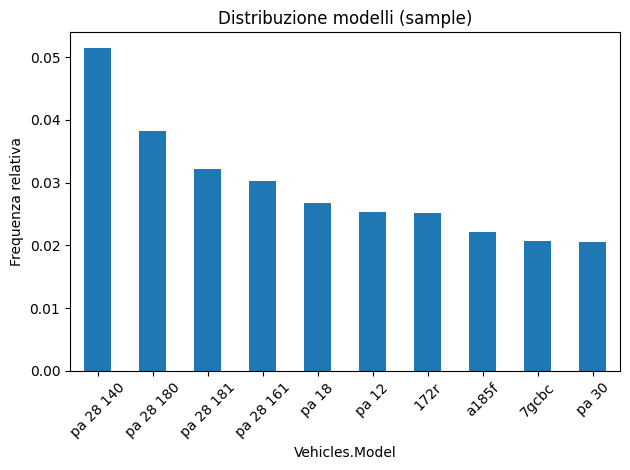

In [18]:
import pandas as pd
from scipy.stats import chisquare
import matplotlib.pyplot as plt

# === 1. Caricamento dati ===

df_sample = pd.read_csv('data_sources/binding/matched_results.csv')

# === 2. Pulizia e normalizzazione del testo ===
def clean_text(s):
    return str(s).lower().strip()

df_ntsb['Vehicles.Model'] = df_ntsb['Vehicles.Model'].apply(clean_text)
df_sample['Vehicles.Model'] = df_sample['Vehicles.Model'].apply(clean_text)

# === 3. Calcolo delle frequenze assolute ===
freq_full = df_ntsb['Vehicles.Model'].value_counts()
freq_sample = df_sample['Vehicles.Model'].value_counts()

# === 4. Allineamento delle categorie comuni ===
common_models = freq_full.index.intersection(freq_sample.index)
counts_sample = freq_sample[common_models]
counts_full = freq_full[common_models]

# === 5. Frequenze attese (scala su dimensione del sample) ===
expected = counts_full / counts_full.sum() * counts_sample.sum()

# === 6. Test Chi-quadrato ===
chi2_stat, p_value = chisquare(f_obs=counts_sample, f_exp=expected)
print(f"Chi² statistic: {chi2_stat:.2f}")
print(f"p-value: {p_value:.4f}")

# === 7. Plot delle frequenze (opzionale) ===
# Mostra i 10 modelli più comuni nel sample
freq_sample_norm = freq_sample / freq_sample.sum()
freq_sample_norm.head(10).plot(kind='bar', title='Distribuzione modelli (sample)', ylabel='Frequenza relativa', rot=45)
plt.tight_layout()
plt.show()


In [7]:
print(freq_full)

Vehicles.Model
172          762
152          366
172s         351
172n         311
182          268
            ... 
dhc-6-300      1
dhc-6-400      1
dhc-8-102      1
dhc-8-103      1
zodiac xl      1
Name: count, Length: 3361, dtype: int64


In [28]:
df_sample = pd.read_csv('data_sources/binding/matched_results.csv')
df_sample.columns

Index(['NtsbNumber', 'EventDate', 'Vehicles.SerialNumber',
       'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model',
       'Matched_Aircraft_Model', 'engine_count', 'engine_type', 'JW_Score',
       'LEV_Score', 'Jac_Score', 'SimilarityScore'],
      dtype='object')

In [29]:
df_sample['engine_type'] = df_sample['engine_type'].astype('category')
freq_sample = df_sample['engine_type'].value_counts()

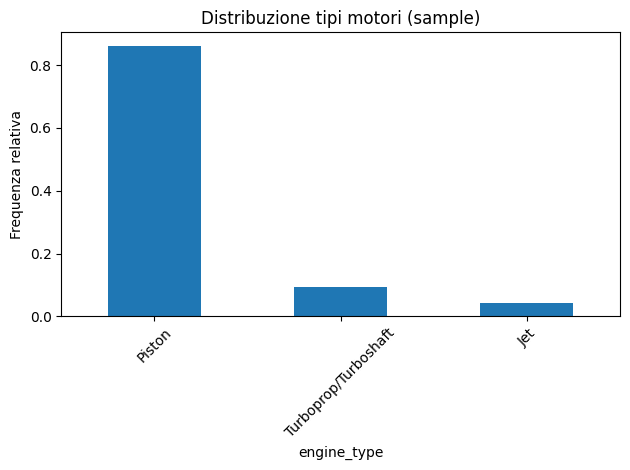

In [30]:
# Mostra i 10 modelli più comuni nel sample
freq_sample_norm = freq_sample / freq_sample.sum()
freq_sample_norm.head(10).plot(kind='bar', title='Distribuzione tipi motori (sample)', ylabel='Frequenza relativa', rot=45)
plt.tight_layout()
plt.show()

## CORRELAZIONE

In [9]:
df_ntsb = pd.read_pickle('data_sources/filtered/ntsb.pkl')
df_ntsb.columns

Index(['Vehicles.VehicleNumber', 'Vehicles.DamageLevel',
       'Vehicles.ExplosionType', 'Vehicles.FireType', 'Vehicles.SerialNumber',
       'Vehicles.Make', 'Vehicles.Model', 'Vehicles.NumberOfEngines',
       'Vehicles.RegistrationNumber', 'Vehicles.FlightOperationType',
       'Vehicles.OperatorName', 'Oid', 'MKey', 'HighestInjury', 'NtsbNumber',
       'ProbableCause', 'City', 'Country', 'EventDate', 'State', 'Agency',
       'EventType', 'AirportId', 'AirportName', 'Latitude', 'Longitude',
       'TotalInjuryCount'],
      dtype='object')

In [10]:
df_airline_traffic = pd.read_pickle('data_sources/filtered/airline.pkl')
df_airline_traffic.columns

Index(['Year', 'Month', 'Dom_Pax', 'Int_Pax', 'Pax', 'Dom_Flt', 'Int_Flt',
       'Flt', 'Dom_LF', 'Int_LF', 'LF'],
      dtype='object')

In [ ]:
df_airline_traffic['Month'] = pd.to_datetime(df_airline_traffic['Month'], format='%Y-%m').dt.month

Correlazione tra numero di voli (Flt) e incidenti mensili: 0.5662


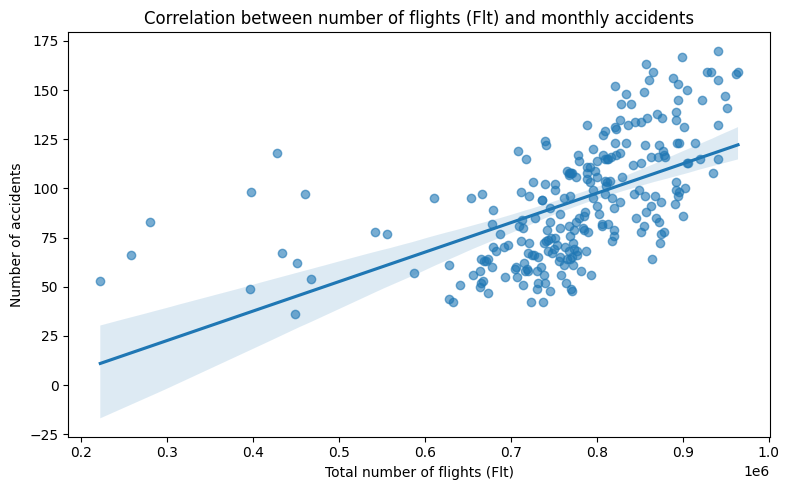

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Prepara i dati sugli incidenti ===
df_ntsb['EventDate'] = pd.to_datetime(df_ntsb['EventDate'], errors='coerce')
df_ntsb['Year'] = df_ntsb['EventDate'].dt.year
df_ntsb['Month'] = df_ntsb['EventDate'].dt.month

# Conta il numero di incidenti per anno e mese
df_incidents_monthly = df_ntsb.groupby(['Year', 'Month']).size().reset_index(name='Num_Incidents')

# === 2. Prepara i dati di traffico aereo ===
df_airline_traffic['Year'] = df_airline_traffic['Year'].astype(int)
df_airline_traffic['Month'] = df_airline_traffic['Month'].astype(int)

# === 3. Merge dei dataset ===
df_merged = pd.merge(df_airline_traffic, df_incidents_monthly, on=['Year', 'Month'], how='left')
df_merged['Num_Incidents'] = df_merged['Num_Incidents'].fillna(0).astype(int)

# === 4. Calcola e visualizza la correlazione tra Flt e incidenti ===
correlation = df_merged['Flt'].corr(df_merged['Num_Incidents'])
print(f"Correlazione tra numero di voli (Flt) e incidenti mensili: {correlation:.4f}")

# === 5. Plot di supporto ===
plt.figure(figsize=(8, 5))
sns.regplot(x='Flt', y='Num_Incidents', data=df_merged, scatter_kws={'alpha':0.6})
plt.title('Correlation between number of flights (Flt) and monthly accidents')
plt.xlabel('Total number of flights (Flt)')
plt.ylabel('Number of accidents')
plt.tight_layout()
plt.show()

